In [0]:
# 需要安装几个非标准库
!pip install BeautifulSoup4
!pip install urllib3

In [0]:
import urllib3
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
import matplotlib.pyplot as plt
from google.colab import files

In [0]:
# 下载数据
def get_data(company):
  url = "http://h1bdata.info/index.php?em=" + company + "&job=&year=All+Years"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  data = soup.find_all("td")
  data_string = []

  for i in range(0, len(data)):
    data_string.append(data[i].get_text())
  
  data_string = np.array(data_string)
  data_table = np.reshape(data_string, (-1,7))
  data_table = pd.DataFrame(data_table,columns=["employer","title","salary","location","submit_date","start_date","case_status"])

  # format salary
  salary_str = data_table.salary.tolist()
  salary_int = [int(s.replace(',', '')) for s in salary_str]
  data_table.salary = salary_int

  # format date
  data_table.submit_date = pd.to_datetime(data_table.submit_date, format='%m/%d/%Y')
  data_table.start_date = pd.to_datetime(data_table.start_date, format='%m/%d/%Y')
  
  return(data_table)

In [0]:
# 上市公司 （FLAG）
FB = get_data("FACEBOOK")
LNKD = get_data("Linkedin")
AMZN = pd.concat([get_data("AMAZON+CORPORATE+LLC"), get_data("AMAZONCOM+SERVICES+INC"), get_data("AMAZON+WEB+SERVICES+INC"), get_data("AMAZON+FULFILLMENT+SERVICES+INC")])
GOOG = pd.concat([get_data("GOOGLE+LLC"), get_data("GOOGLE+INC")])

# 上市公司（其他）
MS = get_data("MICROSOFT+CORPORATION")
AAPL = get_data("Apple+Inc")
NFLX = get_data("NETFLIX+INC")
TWIT = get_data("TWITTER+INC")
SNAP = get_data("SNAP+INC")

# 小公司
UBER = get_data("Uber+Technologies+Inc")
AIRBNB = get_data("Airbnb+Inc")
PINTEREST = get_data("PINTEREST+INC")
LYFT = get_data("LYFT+INC")
ROBIN = get_data("ROBINHOOD+MARKETS+INC")

In [0]:
# 得到所有公司的数据
full_data = pd.concat([GOOG, FB, LNKD, AMZN, UBER, AIRBNB, MS, AAPL, PINTEREST, LYFT, NFLX, TWIT, SNAP, ROBIN], axis=0).reset_index(drop=True)

In [0]:
# 数据清理一
# 职位名称五花八门，进行关键词分类
def clean_titles():
  new_titles = []

  for i in range(0, len(full_data)):
    old_title = full_data.title[i]
    new_title = "OTHER"

    if "ENGINEER" in old_title or "DEVELOPER" in old_title:
      new_title = "ENGINEER"

    if ("PRODUCT MANAGER" in old_title) or ("PROGRAM MANAGER" in old_title and full_data.employer[i] == "MICROSOFT CORPORATION"):
      new_title = "PRODUCT MANAGER" 

    if "RESEARCH SCIENTIST" in old_title:
      new_title = "RESEARCH SCIENTIST"
          
    if ("QUANTITATIVE ANALYST" in old_title) or ("DATA SCIENTIST" in old_title) \
       or ("BUSINESS ANALYST" in old_title) or ("BUSINESS INTELLIGENCE ANALYST" in old_title) \
       or ("BUSINESS ANALYTICS" in old_title) or ("DATA ANALYST" in old_title) \
       or ("DATA ANALYTICS" in old_title) or ("ANALYTICS" in old_title):
      new_title = "BUSINESS ANALYST"   
    new_titles.append(new_title)
  full_data["new_title"] = new_titles  

clean_titles()

In [0]:
# 数据清理二
# 根据递交日期创建年月日
submit_date = full_data.submit_date.tolist()
year = [date.year for date in submit_date]
full_data['submit_year'] = year
month = [date.month for date in submit_date]
full_data['submit_month'] = month

# 根据递交地点创建所在州
location = full_data.location.tolist()
state = [l[-2:] for l in location]
full_data['location_state'] = state

In [0]:
# 数据清理三（忽略warning）
# 清理一下雇主名字
# 所有Google的名字
full_data['employer'][full_data['employer'] == "GOOGLE INC"] = "Google"
full_data['employer'][full_data['employer'] == "GOOGLE LLC"] = "Google"

# facebook
full_data['employer'][full_data['employer'] == "FACEBOOK INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK MIAMI INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK PAYMENTS INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK SERVICES INC"] = "Facebook"

# amazon
full_data['employer'][full_data['employer'] == "AMAZON CORPORATE LLC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZONCOM SERVICES INC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZON WEB SERVICES INC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZON FULFILLMENT SERVICES INC"] = "Amazon"

# other
full_data['employer'][full_data['employer'] == "AIRBNB INC"] = "Airbnb"
full_data['employer'][full_data['employer'] == "LINKEDIN CORPORATION"] = "Linkedin"
full_data['employer'][full_data['employer'] == "APPLE INC"] = "Apple"
full_data['employer'][full_data['employer'] == "LYFT INC"] = "Lyft"
full_data['employer'][full_data['employer'] == "UBER TECHNOLOGIES INC"] = "Uber"
full_data['employer'][full_data['employer'] == "MICROSOFT CORPORATION"] = "Microsoft"
full_data['employer'][full_data['employer'] == "PINTEREST INC"] = "Pinterest"
full_data['employer'][full_data['employer'] == "TWITTER INC"] = "Twitter"
full_data['employer'][full_data['employer'] == "NETFLIX INC"] = "Netflix"
full_data['employer'][full_data['employer'] == "ROBINHOOD MARKETS INC"] = "Robinhood"
full_data['employer'][full_data['employer'] == "SNAP INC"] = "Snapchat"

In [8]:
# 看看我们的数据长什么样子
# 至此，数据清理完毕
full_data.head()

,employer,title,salary,location,submit_date,start_date,case_status,new_title,submit_year,submit_month,location_state
0,Google,1615.29860,115000,"KIRKLAND, WA",2018-01-26,2018-07-25,WITHDRAWN,OTHER,2018,1,WA
1,Google,1615.34491,93000,"MOUNTAIN VIEW, CA",2017-11-28,2018-01-22,DENIED,OTHER,2017,11,CA
2,Google,1615.34491,93000,"MOUNTAIN VIEW, CA",2017-12-07,2018-01-22,WITHDRAWN,OTHER,2017,12,CA
3,Google,ACCOUNT MANAGER (1615.36810),80500,"CAMBRIDGE, MA",2018-03-21,2018-09-20,CERTIFIED,OTHER,2018,3,MA
4,Google,ACCOUNT MANAGER 1615.10639,77500,"ANN ARBOR, MI",2018-02-16,2018-07-30,CERTIFIED,OTHER,2018,2,MI


In [0]:
# 申请数量对比

In [0]:
# 开始画图
# 用的是fivethirtyeigth的格式
# 更多信息，参见https://www.dataquest.io/blog/making-538-plots/
import matplotlib.style as style
style.use('fivethirtyeight')

In [0]:
# 在画图部分，我们只关心部分数据
my_data = full_data[(full_data["new_title"] == "BUSINESS ANALYST")]
my_data = my_data[(my_data["submit_year"] >= 2014) & (my_data["submit_year"] <= 2018)]
my_data = my_data[(my_data["submit_month"] >= 1) & (my_data["submit_month"] <= 3)]
my_data = my_data[(my_data["case_status"] == "CERTIFIED")]

In [0]:
# 第一个问题：公司招人数量

In [0]:
# 做pivot table
ba_data = my_data[(my_data["new_title"] == "BUSINESS ANALYST")]
ba_opening = ba_data.groupby(["submit_year","employer"])[["salary"]].count().reset_index()
my_pivot_table = ba_opening.pivot(index='submit_year', columns="employer").reset_index()

In [0]:
# 我们把公司分分类
# 第一类：市值大上市公司
big_guys = ['Google','Amazon', 'Microsoft', 'Facebook', 'Apple','Linkedin','Netflix','Snapchat', 'Twitter']

# 第二类：独角兽
unicorns = ['Uber', 'Lyft','Airbnb', 'Pinterest']

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


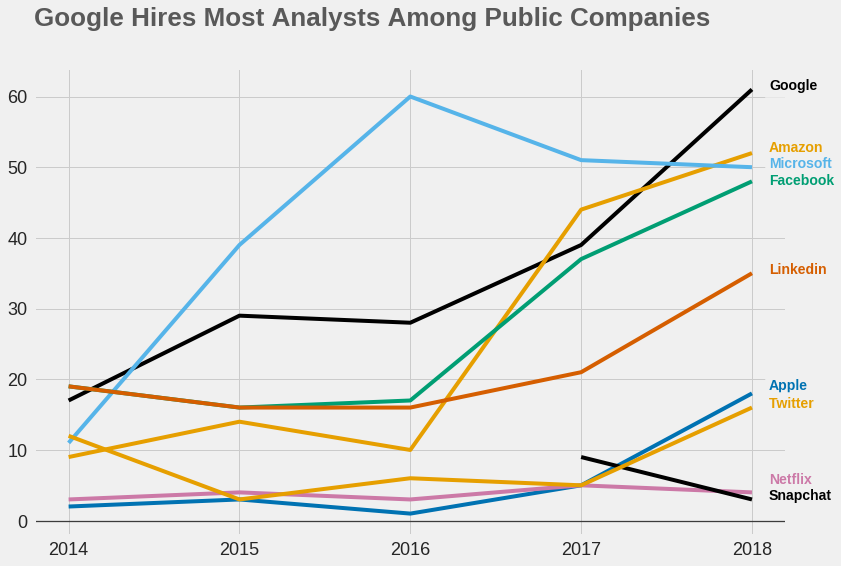

In [14]:
# 可视化大公司的招人数量
# 用的是color-blind friendly的调色盘
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [0,114/255,178/255], [213/255,94/255,0], [204/255, 121/255, 167/255]]

colors = colors + colors

companies = my_data[(my_data["submit_year"] == 2018)].groupby(["employer"])["salary"].count().reset_index().sort_values(["salary"], ascending=False)["employer"].tolist()

# 柱状图
fte_graph = my_pivot_table.salary.plot(x=my_pivot_table.submit_year, y=big_guys, figsize = (12,8), color=colors, legend = False)
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
fte_graph.set_xticks([2014, 2015, 2016, 2017, 2018], minor=False)
fte_graph.xaxis.label.set_visible(False)
fte_graph.set_xlim(left = 2013.8, right = 2018.2)


# 加标题
fte_graph.text(x = 2013.8, y = 70, s = "Google Hires Most Analysts Among Public Companies", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
for i in range(0,len(big_guys)):
  if i == 1:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 0.2, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 
  elif i == 3:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] - 0.5, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 
  elif i == 4:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 0.5, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0')     
  elif i == 6:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 1.2, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0')         
  else:  
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4], s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


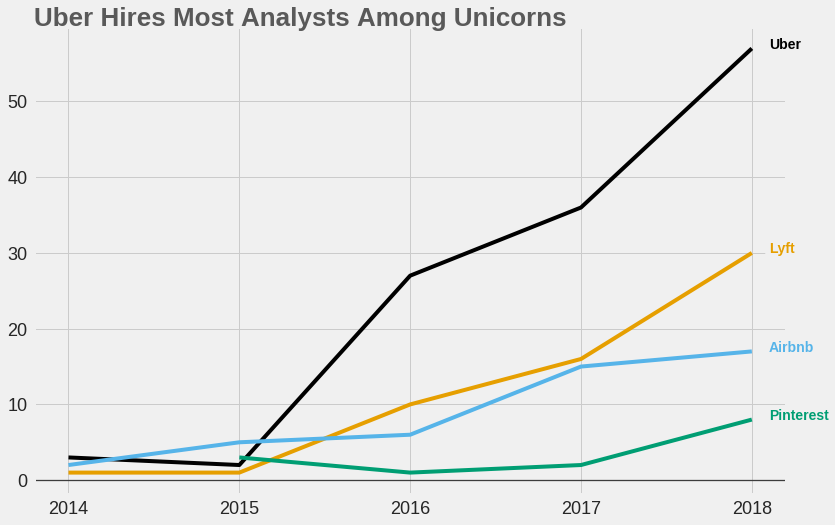

In [15]:
# 可视化小公司的招人数量
fte_graph = my_pivot_table.salary.plot(x=my_pivot_table.submit_year, y=unicorns, figsize = (12,8), color=colors, legend = False)
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
fte_graph.set_xticks([2014, 2015, 2016, 2017, 2018], minor=False)
fte_graph.xaxis.label.set_visible(False)
fte_graph.set_xlim(left = 2013.8, right = 2018.2)

# 加标题
fte_graph.text(x = 2013.8, y = 60, s = "Uber Hires Most Analysts Among Unicorns", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
for i in range(0,len(unicorns)):
  fte_graph.text(x = 2018.1, y = my_pivot_table.salary[unicorns[i]][4], s = unicorns[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 

In [0]:
# 第二个问题：比较不同公司基本工资的差别
ba_salary = my_data[my_data["new_title"] == "BUSINESS ANALYST"].groupby(["employer"])["salary"].median().reset_index().sort_values(by=["salary"],ascending=False)
salary_count = my_data[my_data["new_title"] == "BUSINESS ANALYST"].groupby(["employer"])["salary"].count()

In [0]:
companies = ['Netflix',
 'Airbnb',
 'Lyft',
 'Facebook',
 'Twitter',
 'Google',
 'Pinterest',
 'Microsoft',
 'Linkedin',
 'Apple',
 'Uber',
 'Amazon',
 'Snapchat']

# 创建一个二维数组，包含每个公司的所有工资
my_array = [np.array(my_data[(my_data["employer"] == c) & (my_data["new_title"] == "BUSINESS ANALYST")]["salary"]) for c in companies]

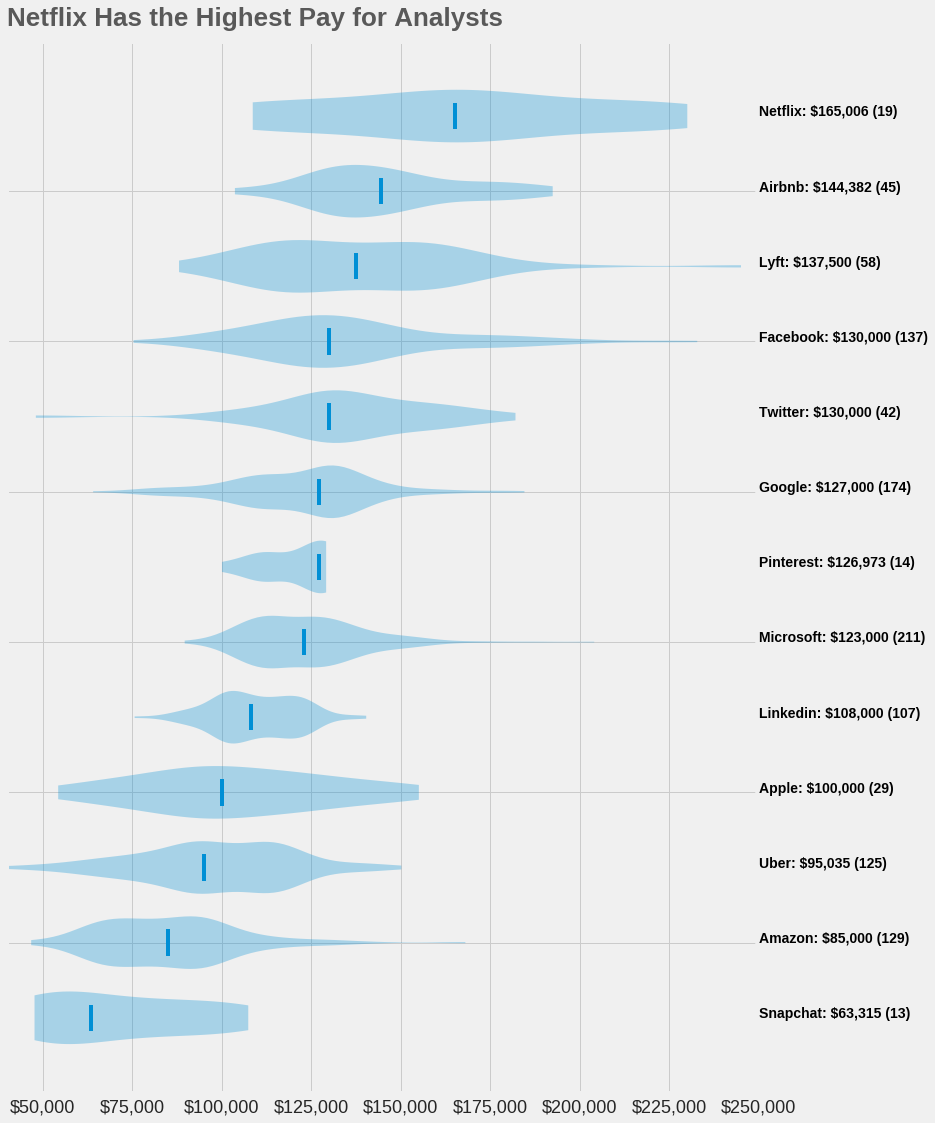

In [18]:
# 可视化
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 18))
pos = [13,12,11,10,9,8,7,6,5,4,3,2,1]
ax.violinplot(my_array, pos, points=80, vert=False, widths=0.7, showmeans=False, showextrema=False, showmedians=True)

ax.tick_params(axis = 'both', which = 'both', labelsize = 18)
ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12,13], minor=True)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(True)
ax.set_yticklabels([])
ax.set_xlim(left=40000, right = 250000)

# 美元符号
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 


# 加标题
ax.text(x = 40000, y = 14.2, s = "Netflix Has the Highest Pay for Analysts", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
for i in range(1,len(companies)+1):
  company = companies[-i]
  median_salary = np.median(my_array[-i])
  salary_count = np.count_nonzero(my_array[-i])
  ax.text(x = 250000, y = i, s = companies[-i] + ': ' + '${:,.0f}'.format(median_salary) + ' (' + str(salary_count) + ')', color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')